In [2]:
#Connecting to Google Drive to access Dataset
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MAIN-PROJECT'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MAIN-PROJECT
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MAIN-PROJECT


In [3]:
%ls

CT_COVID/     resnet_ct_accuracy.png  resnet_ct_loss.png
CT_NonCOVID/  resnet_ct.h5            resnet_weights_ct.hdf5


In [5]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [6]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 10
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID'
noncovid_path = '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [7]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.02.22.20024927-p19-68%2.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.02.25.20021568-p24-111%9.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.02.25.20021568-p24-111%8.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.03.04.20030395-p27-108%7.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_COVID/2020.03.12.20034686-p17-91-5.png']
Total Count:  349
First 5 NonCovid Files:  ['/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/1049.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/1079.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/1048.png', '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/10%2.jpg', '/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/1%1.jpg']
Total Count:  397


In [8]:
# Preparing Labels
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

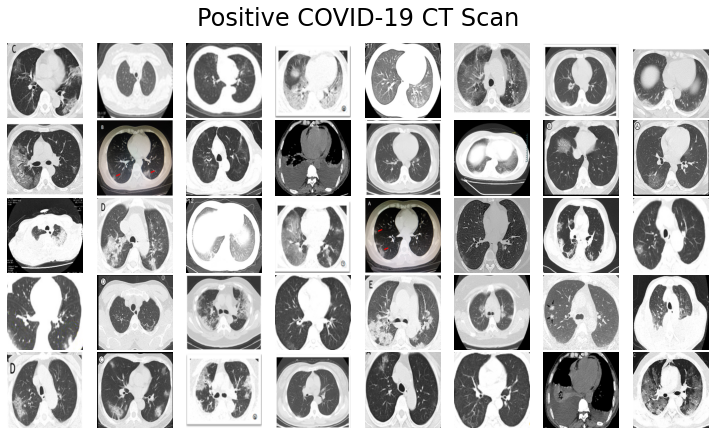

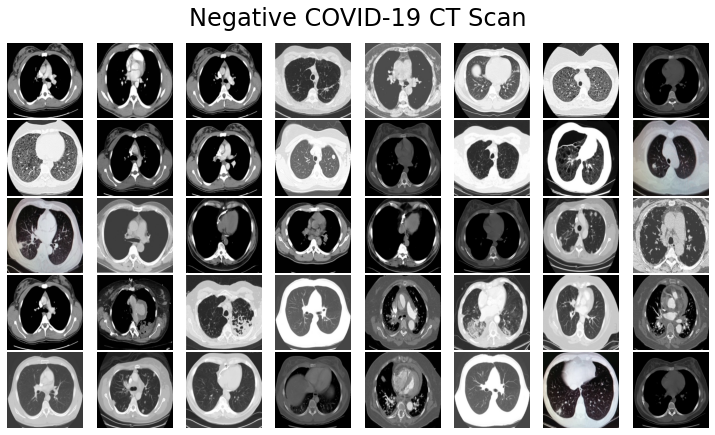

In [9]:
#Visualize First 40 Images from Data set
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

In [10]:
#Normalization
#Model takes images in the form of array of pixels. Hence convert into array and normalize
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [11]:
#Train Test Split
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [12]:
#Building  model
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87924736/87910968 [==============================] - 0s 0us/step


In [13]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
#Image Augmentation
#To train on images at different positions, angles, flips, etc
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [16]:
#Training the model
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/10
18/18 [==============================] - 88s 4s/step - loss: 4.4862 - accuracy: 0.5721 - val_loss: 6.2884 - val_accuracy: 0.4733
Epoch 2/10
18/18 [==============================] - 82s 4s/step - loss: 2.2951 - accuracy: 0.6762 - val_loss: 1.1634 - val_accuracy: 0.7333
Epoch 3/10
18/18 [==============================] - 82s 4s/step - loss: 1.3547 - accuracy: 0.7198 - val_loss: 0.9173 - val_accuracy: 0.7333
Epoch 4/10
18/18 [==============================] - 82s 4s/step - loss: 1.2922 - accuracy: 0.7433 - val_loss: 1.8357 - val_accuracy: 0.6533
Epoch 5/10
18/18 [==============================] - 82s 4s/step - loss: 1.0849 - accuracy: 0.7617 - val_loss: 1.0601 - val_accuracy: 0.7267
Epoch 6/10
18/18 [==============================] - 82s 4s/step - loss: 1.1329 - accuracy: 0.7601 - val_loss: 1.2039 - val_accuracy: 0.7400
Epoch 7/10
18/18 [==============================] - 82s 4s/step - loss: 1.1111 - accuracy: 0.7752 - val_loss: 2.0611 - val_accuracy: 0.6400
Epoch 8/10
18/18 [==

In [17]:
# Taking an image single 

import cv2 

path='/content/drive/MyDrive/MAIN-PROJECT/CT_NonCOVID/1499.png'
image=cv2.imread(path)  
rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
imagetest = cv2.resize(rgb,(224,224))
imagetest = imagetest.reshape(1,224,224,3)

In [18]:
image4test = imagetest / 255

In [19]:
y_predTest = model.predict(image4test)

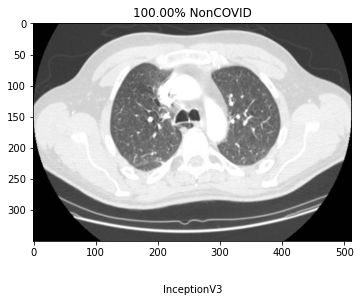

In [20]:
# Predicting the image class( Covid/NonCovid )

prediction=y_predTest
for probability in (prediction):
  if probability[0] > 0.5:
        plt.title('%.2f' % (probability[0]*100) + '% COVID')
        plt.xlabel('\n\nInceptionV3')
  else:
        plt.title('%.2f' % ((1-probability[0])*100) + '% NonCOVID')
        plt.xlabel('\n\nInceptionV3')
  plt.imshow(image)
  plt.show()

In [21]:
# Save Model and Weights
model.save('inception_ct.h5')
model.save_weights('inception_weights_ct.hdf5')

In [22]:
# Load saved model
model = load_model('inception_ct.h5')

In [24]:
#Making Predicions
y_pred = model.predict(X_test, batch_size=batch_size)

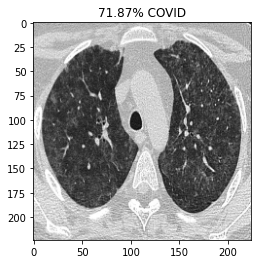

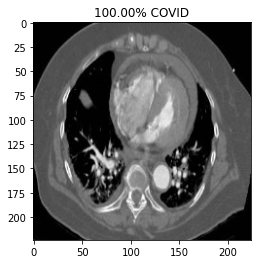

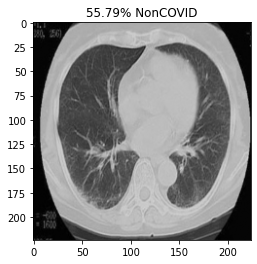

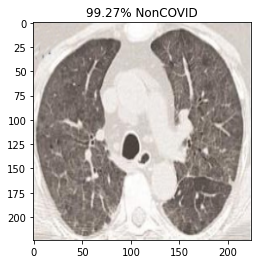

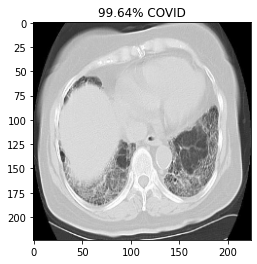

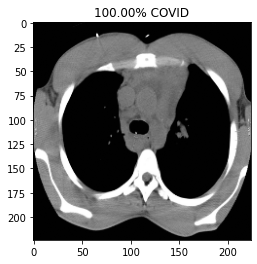

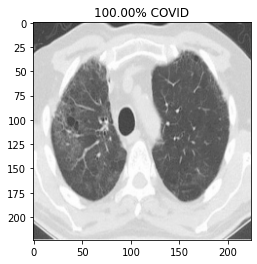

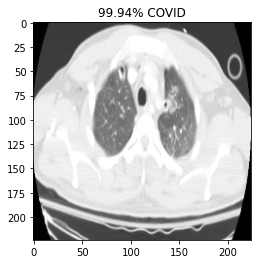

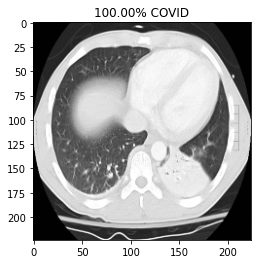

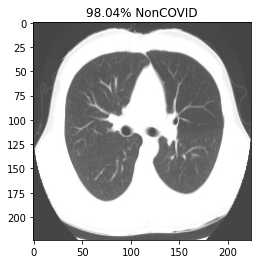

In [25]:
#Visulaizing First 10 predictions
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [26]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

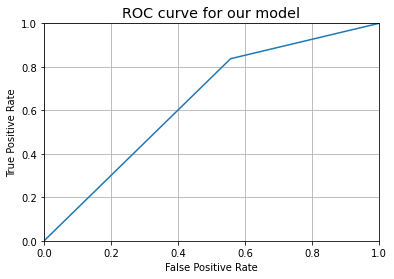

In [27]:
#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


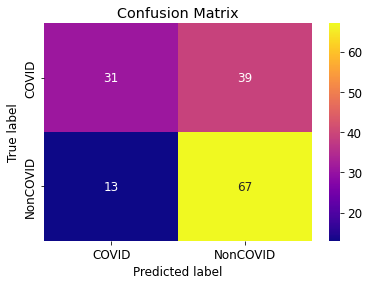

Confusion Matrix with Normalized Values


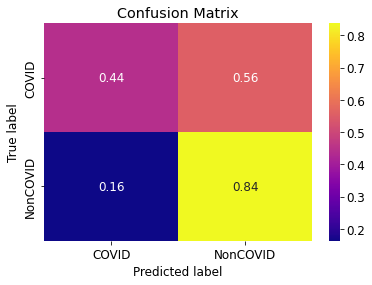

In [28]:
#Plot Confusion Matrix
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [29]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.70      0.44      0.54        70
           1       0.63      0.84      0.72        80

    accuracy                           0.65       150
   macro avg       0.67      0.64      0.63       150
weighted avg       0.67      0.65      0.64       150



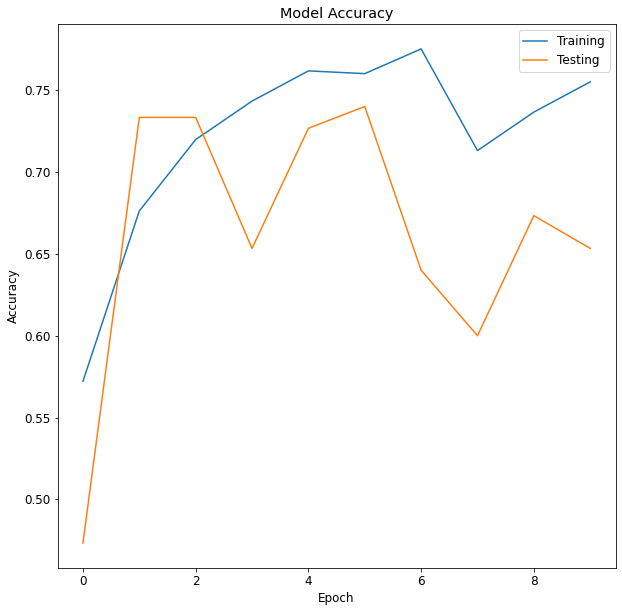

In [30]:
#Accuracy and Loss Plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()

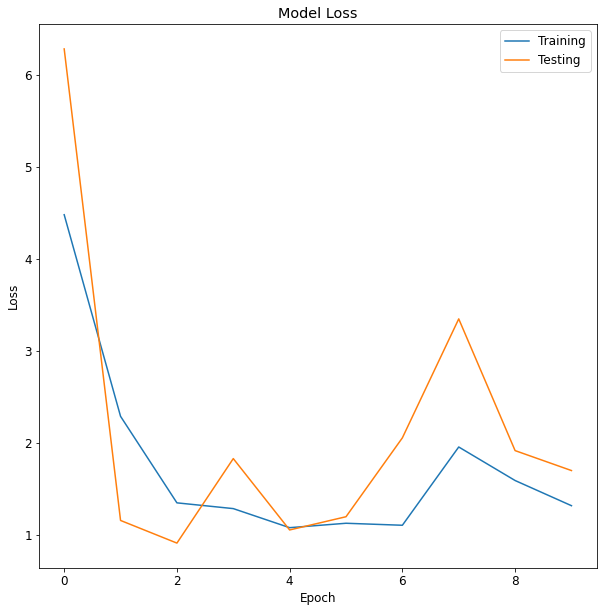

In [31]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()